In [2]:
# Learning Objective: Create a minimal set of features that performs just as well as a more complex feature set
# So far, we've thrown all of our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal set of housing features that will perform equally as well as one that uses all the features in the data set.

In [8]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [9]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [10]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [11]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [12]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9735,-119.6,34.4,29.0,3865.0,814.0,1266.0,613.0,6.0,500001.0
8045,-118.4,34.1,48.0,680.0,131.0,268.0,126.0,4.6,371400.0
5460,-118.2,34.0,36.0,931.0,246.0,732.0,235.0,1.8,142800.0
9118,-119.0,35.4,39.0,598.0,149.0,366.0,132.0,1.9,57900.0
14275,-122.1,37.7,39.0,2069.0,500.0,1408.0,478.0,3.1,153500.0
...,...,...,...,...,...,...,...,...,...
5032,-118.1,34.7,12.0,5319.0,875.0,2439.0,779.0,4.7,131500.0
5789,-118.2,33.8,42.0,1773.0,360.0,815.0,299.0,4.9,406300.0
346,-116.9,33.6,15.0,652.0,149.0,248.0,97.0,2.1,93800.0
3477,-117.9,34.1,33.0,1555.0,361.0,1571.0,386.0,4.1,138200.0


In [13]:
california_housing_dataframe.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


In [14]:
# omits median_house_value
selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
processed_features = selected_features.copy()

In [15]:
 processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])

In [16]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

In [17]:
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [18]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
display.display(training_examples.describe())
display.display(validation_examples.describe())

display.display(training_targets.describe())
display.display(validation_targets.describe())

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2655.6,541.4,1436.3,503.3,3.9,2.0
std,2.1,2.0,12.6,2179.5,422.0,1168.1,385.8,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1470.0,299.0,791.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2137.0,436.0,1173.0,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3167.0,649.0,1728.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.8,2614.9,534.6,1413.3,496.3,3.9,2.0
std,2.1,2.0,12.5,2180.9,420.3,1097.8,381.4,1.9,1.3
min,32.5,-124.3,1.0,15.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1442.0,292.0,786.0,277.0,2.6,1.5
50%,34.2,-118.5,29.0,2106.5,427.0,1150.0,400.5,3.5,1.9
75%,37.7,-118.0,37.0,3102.5,648.0,1693.0,602.2,4.7,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,52.0


,median_house_value
count,12000.0
mean,207.8
std,116.0
min,15.0
25%,119.8
50%,181.0
75%,265.9
max,500.0


,median_house_value
count,5000.0
mean,206.0
std,115.9
min,17.5
25%,119.0
50%,178.4
75%,263.1
max,500.0


In [19]:
# Task 1: Develop a Good Feature Set

In [20]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()
# -1.0: perfect negative correlation
# 0.0: no correlation
# 1.0: perfect positive correlation


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.1
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,-0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [31]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical features to use.
    Returns:
        a set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])


def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [32]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

      periods = 10
      steps_per_period = steps / periods

      # Create a linear regressor object.
      my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
      my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
      linear_regressor = tf.estimator.LinearRegressor(
          feature_columns=construct_feature_columns(training_examples),
          optimizer=my_optimizer
      )

      # Create input functions.
      training_input_fn = lambda: my_input_fn(training_examples, 
                                              training_targets["median_house_value"], 
                                              batch_size=batch_size)
      predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                      training_targets["median_house_value"], 
                                                      num_epochs=1, 
                                                      shuffle=False)
      predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                        validation_targets["median_house_value"], 
                                                        num_epochs=1, 
                                                        shuffle=False)

      # Train the model, but do so inside a loop so that we can periodically assess
      # loss metrics.
      print("Training model...")
      print("RMSE (on training data):")
      training_rmse = []
      validation_rmse = []
      for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
      print("Model training finished.")


      # Output a graph of loss metrics over periods.
      plt.ylabel("RMSE")
      plt.xlabel("Periods")
      plt.title("Root Mean Squared Error vs. Periods")
      plt.tight_layout()
      plt.plot(training_rmse, label="training")
      plt.plot(validation_rmse, label="validation")
      plt.legend()

      return linear_regressor

In [33]:
train_model

<function __main__.train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets)>

In [34]:
california_housing_dataframe.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


Training model...
RMSE (on training data):
  period 00 : 226.81
  period 01 : 215.67
  period 02 : 204.65
  period 03 : 193.75
  period 04 : 183.01
  period 05 : 172.52
  period 06 : 162.17
  period 07 : 152.04
  period 08 : 142.68
  period 09 : 133.22
Model training finished.


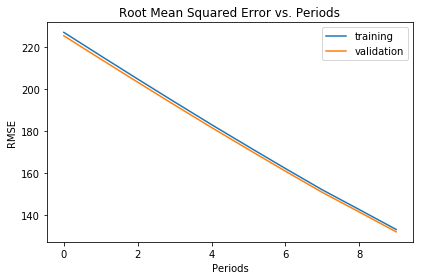

In [35]:
minimal_features = [
    "median_income",
    "rooms_per_person"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets
)

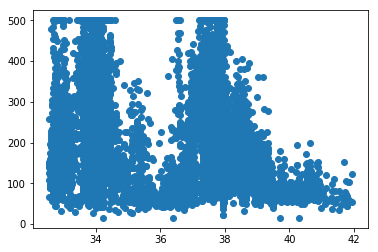

In [36]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [39]:
LATITUDE_RANGES = zip(range(32,44), range(33,45))

In [47]:
def select_and_transform_features(source_df):
    selected_examples = pd.DataFrame()
    selected_examples["median_income"] = source_df["median_income"]
    for r in LATITUDE_RANGES:
        selected_examples["latitude_%d_to_%d" % r] = source_df.apply(
            lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0
        )
    return selected_examples

In [49]:
selected_training_examples = select_and_transform_features(training_examples)

In [50]:
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 227.74
  period 01 : 217.53
  period 02 : 207.40
  period 03 : 197.37
  period 04 : 187.45
  period 05 : 177.67
  period 06 : 168.06
  period 07 : 158.63
  period 08 : 149.42
  period 09 : 140.47
Model training finished.


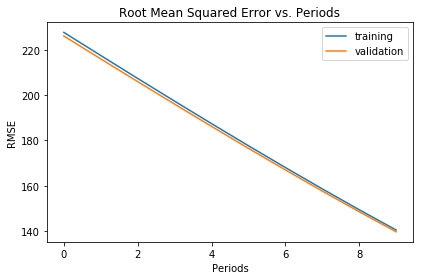

In [51]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)